In [93]:
module Optimizers
using LinearAlgebra

export steepest_descent
function steepest_descent(x₀, A, b, tol)
    isposdef(A) || error("A must be Symmetric Positive Definite")
    x = x₀
    r = r₀ = b - A*x
    
    k = 1
    residuals = []
    
    while true
        if norm(r) / norm(r₀) < tol
            break
        end

        z = A*r
        α = (r'r)/(r'z)
        x = x + α*r
        r = r - α*z
        
        k += 1
        push!(residuals, norm(r))
    end
    
    return residuals, k, x
end

export steepest_descent_naive
function steepest_descent_naive(x₀, A, b, tol)
    isposdef(A) || error("A must be Symmetric Positive Definite")
    x = x₀
    r = r₀ = b - A*x
    
    k = 1
    residuals = []
    
    while true
        if norm(r) / norm(r₀) < tol
            break
        end

        α = (r'r)/(r'A*r)
        x = x + α*r
        r = b - A*x
        
        k += 1
        push!(residuals, norm(r))
    end
    
    return residuals, k, x
end

export conjugate_gradient_naive
function conjugate_gradient_naive(x₀, A, b, tol)
    isposdef(A) || error("A must be Symmetric Positive Definite")
    x = x₀
    r = r₀ = b - A*x
    d = r
    
    k = 1
    rs = []
    
    while true
         if norm(r / norm(r₀)) < tol
            break
        end
        
        α = (r'd)/(d'A*d)
        x = x + α*d
        r = b - A*x
        
        β = - (d'A*r)/(d'*A*d)
        d = r + β * d
        
        k += 1
        push!(rs, norm(r))
    end
    
    return rs, k, x
end

export conjugate_gradient
function conjugate_gradient(x₀, A, b, tol)
    isposdef(A) || error("A must be Symmetric Positive Definite")
    x = x₀
    r = r₀ = b - A*x
    d = r
    
    k = 1
    rs = []
    
    while true
         if norm(r / norm(r₀)) < tol
            break
        end
        
        z = A*d
        
        α = (r'r)/(d'z)
        x = x + α*d
        
        r_old = copy(r)
        r = r_old - α*z
        
        β = (r'r)/(r_old'r_old) # era qua l'errore
        d = r + β*d
        
        k += 1
        push!(rs, norm(r))
    end
    
    return rs, k, x
end
end

import Main.Optimizers

In [95]:
Optimizers.conjugate_gradient(x₀, A, b, 1e-8)[2]

41

In [94]:
Optimizers.conjugate_gradient(x₀, A, b, 1e-8)[2]

41

---

In [52]:
using LinearAlgebra, Plots, SparseArrays

In [78]:
n = Int(1e4)
α = 2.05

A = sparse(α*I, n, n)
A[diagind(A, -1)] = ones(n-1)
A[diagind(A, 1)] = ones(n-1)

b = A*ones(n)

x₀ = -0.5*ones(n);

---

# Tolerance vs Number of iterations

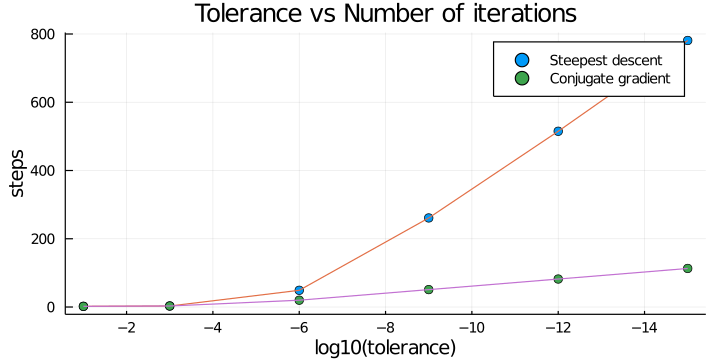

In [96]:
scatter(
    [-1, -3, -6, -9, -12, -15],
    logtol -> Main.Optimizers.steepest_descent(x₀, A, b, 10^(logtol))[2],
    xflip=true,
    xlabel="log10(tolerance)", ylabel="steps", label="Steepest descent",
    dpi=30,
    size=(600, 300)
)
plot!(
    [-1, -3, -6, -9, -12, -15],
    logtol -> Main.Optimizers.steepest_descent(x₀, A, b, 10^(logtol))[2],
    xflip=true,
    xlabel="log10(tolerance)", ylabel="steps", label=false
)
scatter!(
    [-1, -3, -6, -9, -12, -15],
    logtol -> Main.Optimizers.conjugate_gradient(x₀, A, b, 10^(logtol))[2],
    xflip=true,
    xlabel="log10(tolerance)", ylabel="steps", label="Conjugate gradient"
)
plot!(
    [-1, -3, -6, -9, -12, -15],
    logtol -> Main.Optimizers.conjugate_gradient(x₀, A, b, 10^(logtol))[2],
    xflip=true,
    xlabel="log10(tolerance)", ylabel="steps", label=false
)
title!("Tolerance vs Number of iterations")

---

# Optimizations

In [19]:
using BenchmarkTools

In [97]:
@benchmark Main.Optimizers.steepest_descent_naive(x₀, $A, $b, 1e-8) setup=(x₀=randn(n))

BenchmarkTools.Trial: 
  memory estimate:  188.04 MiB
  allocs estimate:  5364
  --------------
  minimum time:     93.257 ms (5.43% GC)
  median time:      102.605 ms (6.09% GC)
  mean time:        130.042 ms (6.04% GC)
  maximum time:     292.948 ms (6.23% GC)
  --------------
  samples:          40
  evals/sample:     1

In [98]:
@benchmark Main.Optimizers.steepest_descent(x₀, $A, $b, 1e-8) setup=(x₀=randn(n))

BenchmarkTools.Trial: 
  memory estimate:  187.27 MiB
  allocs estimate:  5342
  --------------
  minimum time:     45.498 ms (11.44% GC)
  median time:      56.033 ms (10.86% GC)
  mean time:        56.675 ms (11.85% GC)
  maximum time:     76.074 ms (13.73% GC)
  --------------
  samples:          89
  evals/sample:     1

In [99]:
@benchmark Main.Optimizers.conjugate_gradient_naive(x₀, $A, $b, 1e-8) setup=(x₀=randn(n))

BenchmarkTools.Trial: 
  memory estimate:  56.36 MiB
  allocs estimate:  1500
  --------------
  minimum time:     32.128 ms (4.55% GC)
  median time:      36.023 ms (4.11% GC)
  mean time:        39.488 ms (5.52% GC)
  maximum time:     128.929 ms (9.99% GC)
  --------------
  samples:          127
  evals/sample:     1

In [100]:
@benchmark Main.Optimizers.conjugate_gradient(x₀, $A, $b, 1e-8) setup=(x₀=randn(n))

BenchmarkTools.Trial: 
  memory estimate:  51.09 MiB
  allocs estimate:  1362
  --------------
  minimum time:     11.936 ms (11.49% GC)
  median time:      16.908 ms (9.93% GC)
  mean time:        19.668 ms (11.89% GC)
  maximum time:     78.725 ms (23.64% GC)
  --------------
  samples:          254
  evals/sample:     1

---

## More Conjugate Gradient analyses

### When α is 4, K2(A) < 3

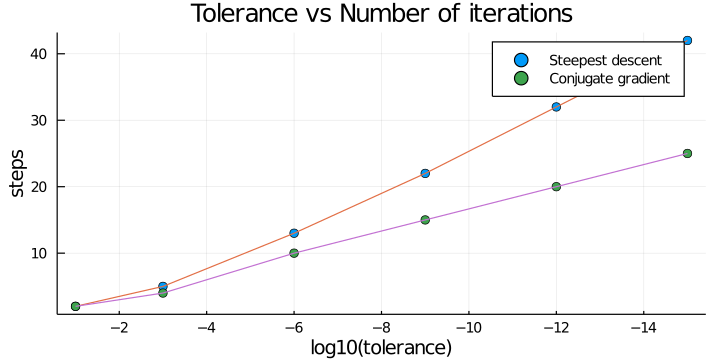

In [63]:
n = Int(1e2)
α = 4

A = sparse(α*I, n, n)
A[diagind(A, -1)] = ones(n-1)
A[diagind(A, 1)] = ones(n-1)

b = A*ones(n)

x₀ = -0.5*ones(n);

scatter(
    [-1, -3, -6, -9, -12, -15],
    logtol -> Main.Optimizers.steepest_descent(x₀, A, b, 10^(logtol))[2],
    xflip=true,
    xlabel="log10(tolerance)", ylabel="steps", label="Steepest descent",
    dpi=30,
    size=(600, 300)
)
plot!(
    [-1, -3, -6, -9, -12, -15],
    logtol -> Main.Optimizers.steepest_descent(x₀, A, b, 10^(logtol))[2],
    xflip=true,
    xlabel="log10(tolerance)", ylabel="steps", label=false
)
scatter!(
    [-1, -3, -6, -9, -12, -15],
    logtol -> Main.Optimizers.conjugate_gradient(x₀, A, b, 10^(logtol))[2],
    xflip=true,
    xlabel="log10(tolerance)", ylabel="steps", label="Conjugate gradient"
)
plot!(
    [-1, -3, -6, -9, -12, -15],
    logtol -> Main.Optimizers.conjugate_gradient(x₀, A, b, 10^(logtol))[2],
    xflip=true,
    xlabel="log10(tolerance)", ylabel="steps", label=false
)
title!("Tolerance vs Number of iterations")

### When α is 2, K2(A) < n^2

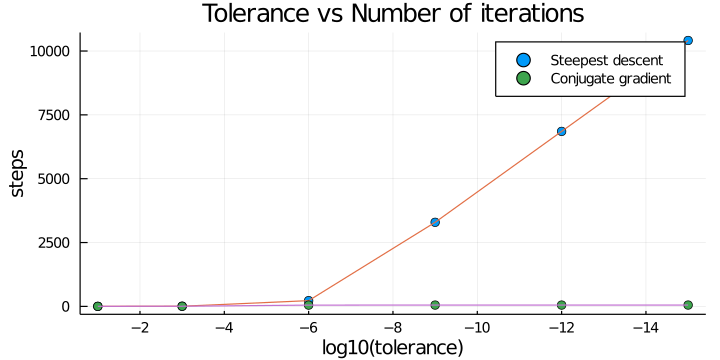

In [64]:
n = Int(1e2)
α = 2

A = sparse(α*I, n, n)
A[diagind(A, -1)] = ones(n-1)
A[diagind(A, 1)] = ones(n-1)

b = A*ones(n)

x₀ = -0.5*ones(n);

scatter(
    [-1, -3, -6, -9, -12, -15],
    logtol -> Main.Optimizers.steepest_descent(x₀, A, b, 10^(logtol))[2],
    xflip=true,
    xlabel="log10(tolerance)", ylabel="steps", label="Steepest descent",
    dpi=30,
    size=(600, 300)
)
plot!(
    [-1, -3, -6, -9, -12, -15],
    logtol -> Main.Optimizers.steepest_descent(x₀, A, b, 10^(logtol))[2],
    xflip=true,
    xlabel="log10(tolerance)", ylabel="steps", label=false
)
scatter!(
    [-1, -3, -6, -9, -12, -15],
    logtol -> Main.Optimizers.conjugate_gradient(x₀, A, b, 10^(logtol))[2],
    xflip=true,
    xlabel="log10(tolerance)", ylabel="steps", label="Conjugate gradient"
)
plot!(
    [-1, -3, -6, -9, -12, -15],
    logtol -> Main.Optimizers.conjugate_gradient(x₀, A, b, 10^(logtol))[2],
    xflip=true,
    xlabel="log10(tolerance)", ylabel="steps", label=false
)
title!("Tolerance vs Number of iterations")

### When α is 2.1, 3 < K2(A) < n^2

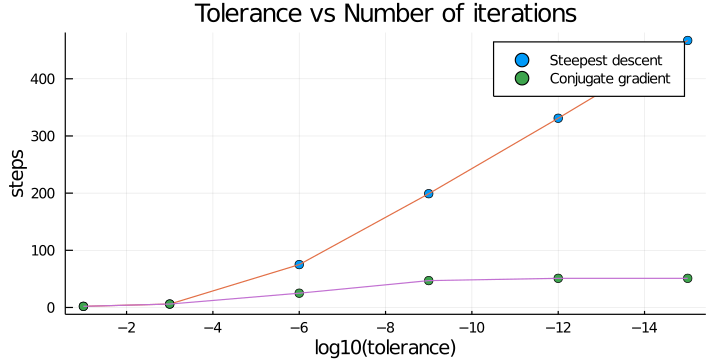

In [105]:
n = Int(1e2)
α = 2.1

A = sparse(α*I, n, n)
A[diagind(A, -1)] = ones(n-1)
A[diagind(A, 1)] = ones(n-1)

b = A*ones(n)

x₀ = -0.5*ones(n);

scatter(
    [-1, -3, -6, -9, -12, -15],
    logtol -> Main.Optimizers.steepest_descent(x₀, A, b, 10^(logtol))[2],
    xflip=true,
    xlabel="log10(tolerance)", ylabel="steps", label="Steepest descent",
    dpi=30,
    size=(600, 300)
)
plot!(
    [-1, -3, -6, -9, -12, -15],
    logtol -> Main.Optimizers.steepest_descent(x₀, A, b, 10^(logtol))[2],
    xflip=true,
    xlabel="log10(tolerance)", ylabel="steps", label=false
)
scatter!(
    [-1, -3, -6, -9, -12, -15],
    logtol -> Main.Optimizers.conjugate_gradient(x₀, A, b, 10^(logtol))[2],
    xflip=true,
    xlabel="log10(tolerance)", ylabel="steps", label="Conjugate gradient"
)
plot!(
    [-1, -3, -6, -9, -12, -15],
    logtol -> Main.Optimizers.conjugate_gradient(x₀, A, b, 10^(logtol))[2],
    xflip=true,
    xlabel="log10(tolerance)", ylabel="steps", label=false
)
title!("Tolerance vs Number of iterations")

---

## Incomplete Cholesky preconditioning

In [104]:
using Preconditioners

┌ Info: Precompiling Preconditioners [af69fa37-3177-5a40-98ee-561f696e4fcd]
└ @ Base loading.jl:1278


In [134]:
?LowerTriangular

search: LowerTriangular UnitLowerTriangular



```
LowerTriangular(A::AbstractMatrix)
```

Construct a `LowerTriangular` view of the matrix `A`.

# Examples

```jldoctest
julia> A = [1.0 2.0 3.0; 4.0 5.0 6.0; 7.0 8.0 9.0]
3×3 Array{Float64,2}:
 1.0  2.0  3.0
 4.0  5.0  6.0
 7.0  8.0  9.0

julia> LowerTriangular(A)
3×3 LowerTriangular{Float64,Array{Float64,2}}:
 1.0   ⋅    ⋅
 4.0  5.0   ⋅
 7.0  8.0  9.0
```


In [125]:
Main.Optimizers.conjugate_gradient(x₀, PA)

CholeskyPreconditioner{Float64,SparseMatrixCSC{Float64,Int64}}([1.449137674618944 0.0 … 0.0 0.0; 0.6900655593423543 1.2742878496672265 … 0.0 0.0; … ; 0.0 0.0 … 1.449137674618944 0.0; 0.0 0.0 … 0.6900655593423543 0.9454976127316066], 2)

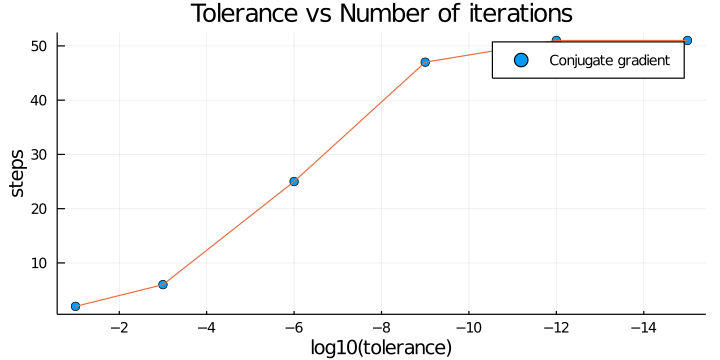

In [110]:
n = Int(1e2)
α = 2.1

A = sparse(α*I, n, n)
A[diagind(A, -1)] = ones(n-1)
A[diagind(A, 1)] = ones(n-1)

b = A*ones(n)

x₀ = -0.5*ones(n);

scatter(
    [-1, -3, -6, -9, -12, -15],
    logtol -> Main.Optimizers.conjugate_gradient(x₀, A, b, 10^(logtol))[2],
    xflip=true,
    xlabel="log10(tolerance)", ylabel="steps", label="Conjugate gradient",
    dpi=30,
    size=(600, 300)
)
plot!(
    [-1, -3, -6, -9, -12, -15],
    logtol -> Main.Optimizers.conjugate_gradient(x₀, A, b, 10^(logtol))[2],
    xflip=true,
    xlabel="log10(tolerance)", ylabel="steps", label=false
)
title!("Tolerance vs Number of iterations")